In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from stable_baselines3 import SAC
from KSEnv import KS_Env


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/py310/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/py310/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/py310/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/py310/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/py310/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/py310/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/py310/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

In [2]:
def make_env(**kwargs):
    base_args = {
        'L':11.6,
        'actuator_loss_weight':1,
        'seed':None,
        'device':"cpu",
        'N':32,
        'dt':0.01,
        'max_steps':5000,
        'u0':None,
        'lim':1,
        'plot':True,
        'verbose':True,
        'controller':'nonlin',
        'sees_state':True,
        'observation_type':'state',
        'reward_type':'trivial',
        'pullback_state':True,
        'noise':0,
        'initial_amp': 0.1,
        'continuous':False
    }

    base_args.update(kwargs)

    return KS_Env(**base_args)

env = make_env()

In [3]:
model = SAC.load("runs/reward_time/controller_nonlin/observation_state/L_11.6_gamma_0.99_buffer_200000_lim_1.0/sac_ks_final.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


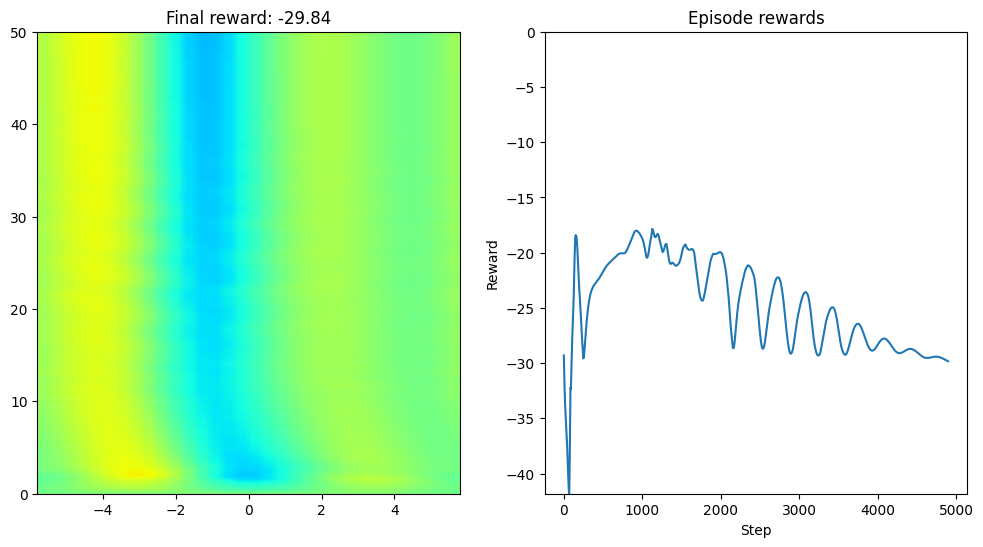

Mean reward: -9.162075516087999 +/- 2.7022372436725024


In [9]:
from stable_baselines3.common.evaluation import evaluate_policy
# evaluate the model
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)
print(f"Mean reward: {mean_reward/25000} +/- {std_reward/25000}")

In [6]:
env2 = make_env(observation_type='state_plus_time')
model2 = SAC.load("runs/reward_time/controller_nonlin/observation_state_plus_time/L_11.6_gamma_0.99_buffer_200000_lim_1.0/sac_ks_final.zip", env=env2)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


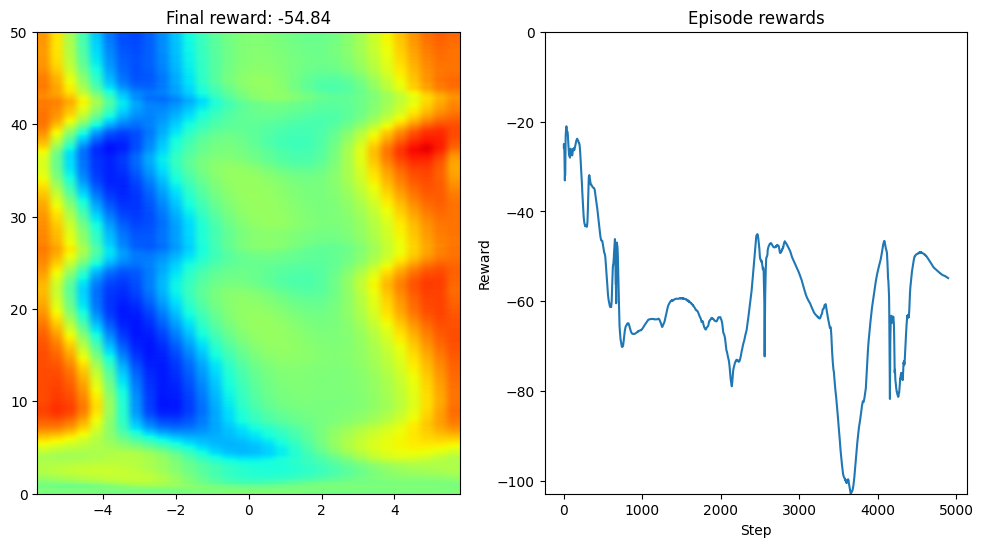

Mean reward: -11.157510997088 +/- 1.329493978960719


In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
# evaluate the model
mean_reward, std_reward = evaluate_policy(model2, model2.get_env(), n_eval_episodes=5)
print(f"Mean reward: {mean_reward/25000} +/- {std_reward/25000}")

In [12]:
env3 = make_env(L=7, controller='unforced')
model3 = SAC.load("runs/reward_trivial/controller_nonlin/observation_state/L_7_gamma_0.99_buffer_200000_lim_1.0/sac_ks_final.zip", env=env3)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


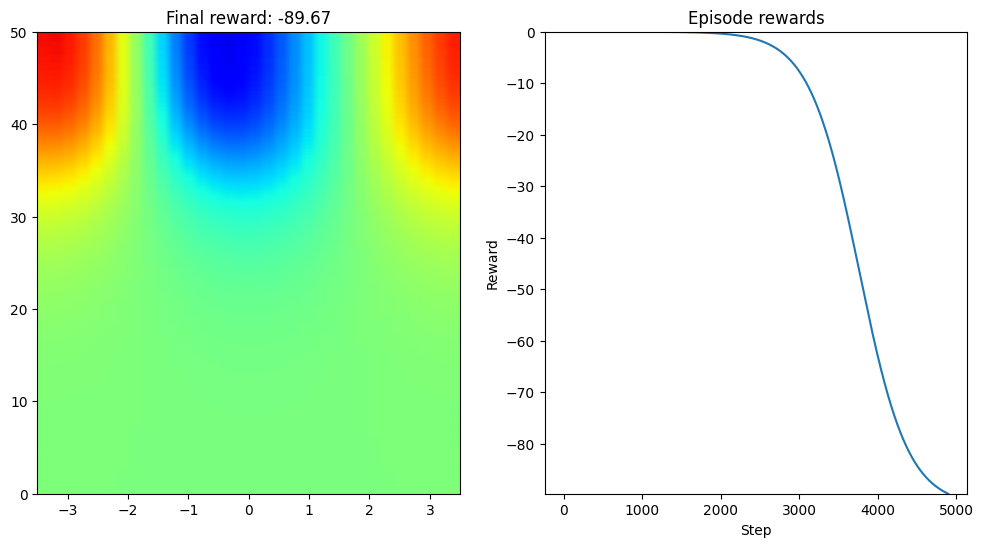

Mean reward: -3.606873730648 +/- 1.6917054892673928


In [14]:
from stable_baselines3.common.evaluation import evaluate_policy
# evaluate the model
mean_reward, std_reward = evaluate_policy(model3, model3.get_env(), n_eval_episodes=5)
print(f"Mean reward: {mean_reward/25000} +/- {std_reward/25000}")